# KNN, рак и спам
__Суммарное количество баллов: 12__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
import heapq
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    cancer_dataset = pandas.read_csv(path_to_csv)
    coded_label = {"label": {"M": 1, "B": 0}}
    cancer_dataset = cancer_dataset.replace(coded_label)
    cancer_dataset_shuffled = cancer_dataset.sample(frac = 1).reset_index()
    cancer_dataset_shuffled.drop('index', axis = 1, inplace = True)
    y = np.array(cancer_dataset_shuffled.iloc[:, 0])
    X = np.array(cancer_dataset_shuffled.iloc[:, 1:])
    return X, y


def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    spam_dataset = pandas.read_csv(path_to_csv)
    spam_dataset_shuffled = spam_dataset.sample(frac = 1).reset_index()
    spam_dataset_shuffled.drop('index', axis = 1, inplace = True)
    y = np.array(spam_dataset_shuffled.iloc[:, -1])
    X = np.array(spam_dataset_shuffled.iloc[:, :-1])
    return X, y

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [3]:
def train_test_split(X: np.array, y: np.array, ratio: float) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    border = int(ratio * len(y))
    X_train = X[:border]
    X_test = X[border:]
    y_train = y[:border]
    y_test = y[border:]
    return X_train, y_train, X_test, y_test

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [4]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    precision, recall = [], []
    classes = np.unique(y_true)
    for i in range(len(classes)):
        main_class = classes[i]
        y_true_new = [0] * len(y_true)
        y_pred_new = [0] * len(y_true)
        TP, FP, TN, FN = 0, 0, 0, 0
        for j in range(len(y_true)):
            if y_true[j] == main_class:
                y_true_new[j] = 1 
            if y_pred[j] == main_class:
                y_pred_new[j] = 1 
        for k in range(len(y_true)):
            if y_true_new[k] == y_pred_new[k] and y_true_new[k] == 1:
                TP += 1
            elif y_true_new[k] == y_pred_new[k] and y_true_new[k] == 0:
                TN += 1
            elif y_true_new[k] != y_pred_new[k] and y_true_new[k] == 1:
                FN += 1
            elif y_true_new[k] != y_pred_new[k] and y_true_new[k] == 0:
                FP += 1
        precision_new = TP/(TP + FP)
        recall_new = TP/(TP + FN)
        precision.append(precision_new)
        recall.append(recall_new)
    accuracy = sum(y_true == y_pred)/len(y_pred)
    
    return np.array(precision), np.array(recall), accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [5]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [6]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь приступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [7]:
class Node():
    def __init__(self, median = None, dim = None, left = None, right = None, points = None):
        self.dim = dim
        self.median = median
        self.left = left
        self.right = right
        self.points = points
        
class KDTree:
    
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """               
        def _build_tree(X, indices, dim, leaf_size):            
            if X is None:
                return None            
            if leaf_size >= len(X):
                return Node(points=(X, indices))            
            indices_ord = X[:, dim].argsort()
            X = X[indices_ord]
            indices = indices[indices_ord]
            median = len(indices) // 2
            next_dim = (dim + 1) % len(X[0])
            return Node(median = X[median],dim = dim, left = _build_tree(X[:median], indices[:median], next_dim, leaf_size), right = _build_tree(X[median + 1:], indices[median + 1:], next_dim, leaf_size), points = indices[median])
            
        self.root = _build_tree(X.copy(), np.arange(X.shape[0]), 0, leaf_size)
        
    def distance(self, a, b):
        return np.linalg.norm(a - b)
            
    def query_one_element(self, element, k):
        
        result = []            
        def find(curent_point):            
            if curent_point is None:
                return None            
            if curent_point.median is None:                
                for x, i in zip(*curent_point.points):
                    d = -self.distance(element, x)                    
                    if len(result) < k:
                         heapq.heappush(result, (d, i))                            
                    elif d > result[0][0]:
                        heapq.heappushpop(result,(d, i))            
            else:                
                branch_to_visit, opposite_branch = None, None
                if element[curent_point.dim] < curent_point.median[curent_point.dim]:
                    branch_to_visit, branch_other = curent_point.left, curent_point.right
                else:
                    branch_to_visit, branch_other = curent_point.right, curent_point.left
                    
                d = -self.distance(element, curent_point.median)                
                if len(result) < k:
                    heapq.heappush(result, (d, curent_point.points))
                    
                elif d > result[0][0]:
                    heapq.heappushpop(result,(d, curent_point.points))                    
                find(branch_to_visit)
                if -abs(element[curent_point.dim] - curent_point.median[curent_point.dim]) > result[0][0]:
                    find(branch_other)
        
        find(self.root)
        result.sort(key = lambda x: - x[0])
        res = list(i[1] for i in result)
        return res
    
    def query(self, X, k):
        full = []
        for i in range(len(X)):
            full.append(self.query_one_element(X[i], k))
        return full 

In [8]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [18]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """
        self.kdtree = None
        self.k = n_neighbors
        self.leaf_size = leaf_size
 
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """  
        self.y = copy.deepcopy(y)
        self.norm = np.max(X, axis = 0) - np.min(X, axis = 0)
        self.kdtree = KDTree(X / self.norm, leaf_size = self.leaf_size)
        self.classes = len(np.unique(y))

        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        closest_ids = self.kdtree.query(X / self.norm, self.k)
        nearest_classes = [[self.y[i] for i in x_closest] for x_closest in closest_ids]
        proba = []
        for nc in nearest_classes:
            classes, counts = np.unique(nc, return_counts = True)
            p = np.zeros(self.classes)
            p[classes] = counts
            p /= np.sum(p)
            proba.append(p)
        return proba
 
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)

Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

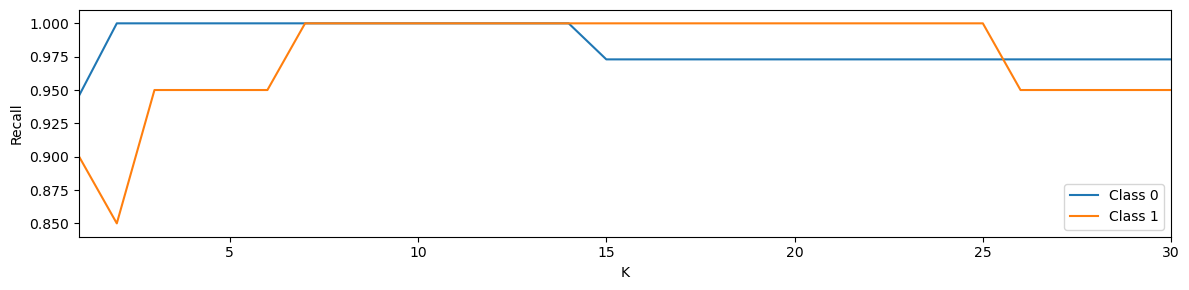

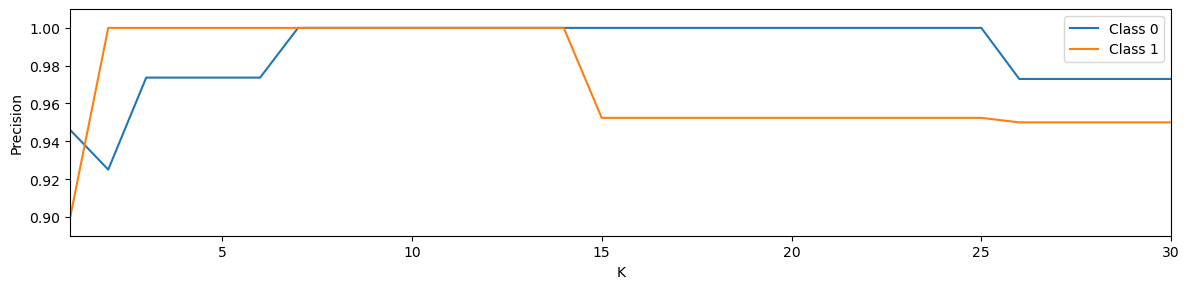

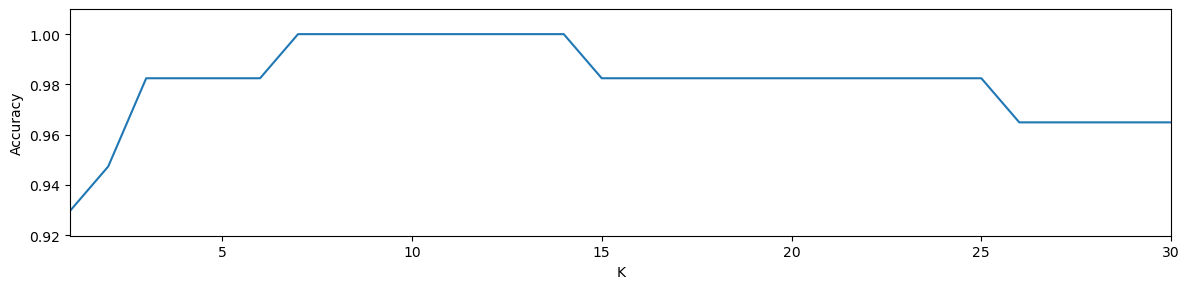

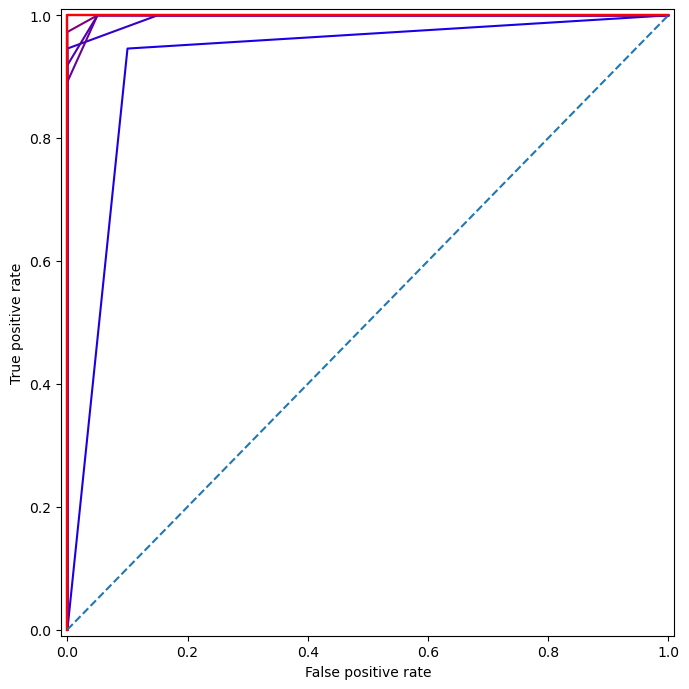

In [19]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

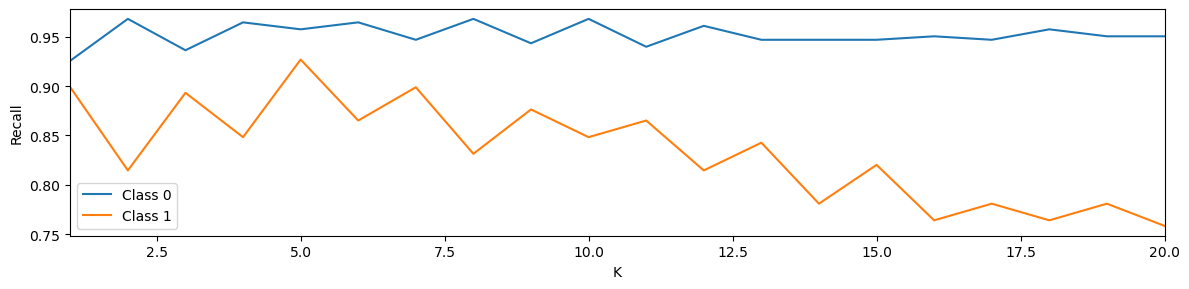

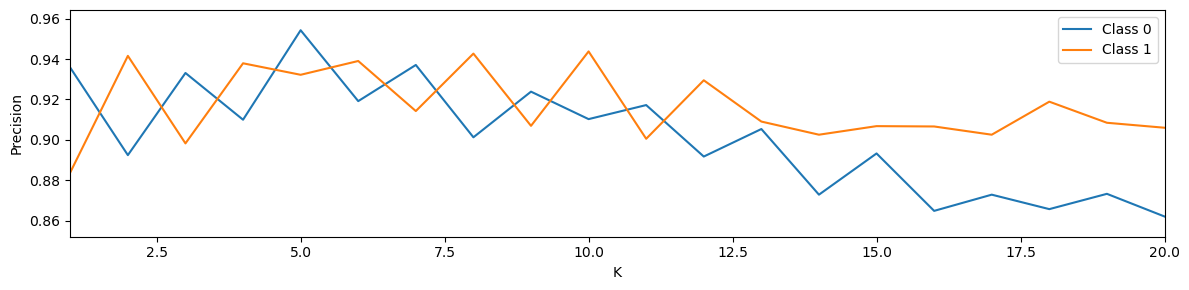

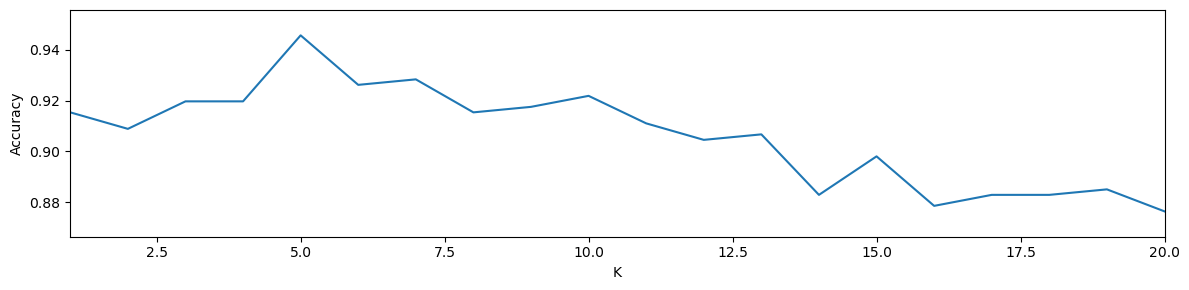

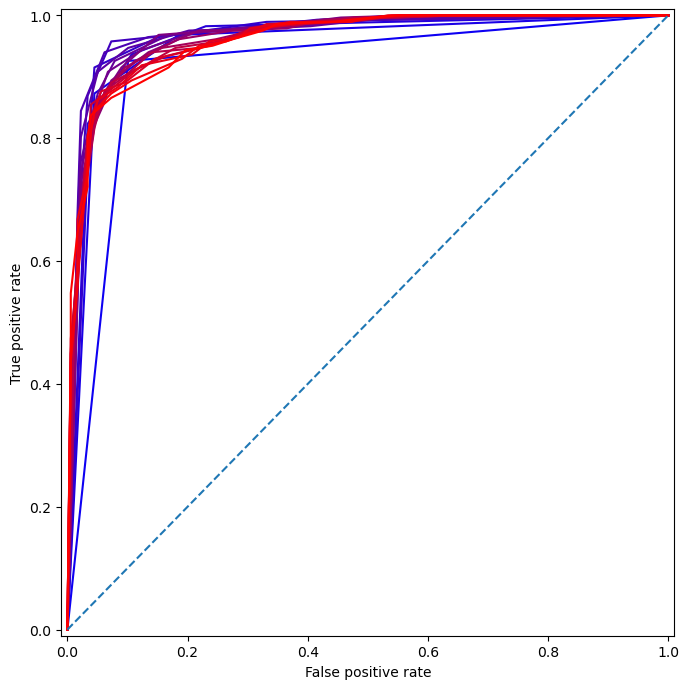

In [20]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)